# How does the system perform?

This notebook will look the following:

* How long do users wait to answer questions?
* How long do users wait for the network to respond?
* How many simultaneous users do we have?
* How many simultaneous requests are served?


In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('seaborn')

In [2]:
import caption_contest_data as ccd
responses = ccd.responses(577)
print("Number of responses:", len(responses))
responses.columns

Number of responses: 389898


Index(['alg_label', 'network_delay', 'participant_uid', 'response_time',
       'target', 'target_id', 'target_reward', 'timestamp_query_generated',
       'label', 'contest', 'filename'],
      dtype='object')

In [3]:
responses.iloc[0]

alg_label                                                                KLUCB
network_delay                                                         0.670163
participant_uid              eea58658d9d40ceaf97f0bccbfa324_BuIKwH3xGWWASxp...
response_time                                                           28.324
target                       Your mother and I don't think working from hom...
target_id                                                                 4181
target_reward                                                                2
timestamp_query_generated                           2017-07-28 17:05:39.090118
label                                                           somewhat_funny
contest                                                                    577
filename                                                     577-responses.csv
Name: 0, dtype: object

## Response time 
How long does the average user wait before providing a respose? That data is recorded in the responses and we can plot a histogram. 

We know that waiting for something to happen is characterized by an [exponential random variable]. Can we fit the PDF of an exponential random variable to the reponse time we see? 

[exponential random variable]:https://en.wikipedia.org/wiki/Exponential_distribution

In [4]:
most_responses = (responses['response_time'] >= 0) & (responses['response_time'] <= 15) 
df = responses[most_responses].copy()

/Users/scott/anaconda3/envs/ccd-api3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/hist.py:62: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  n, bins, patches = ax.hist(y, bins=bins, bottom=bottom, **kwds)


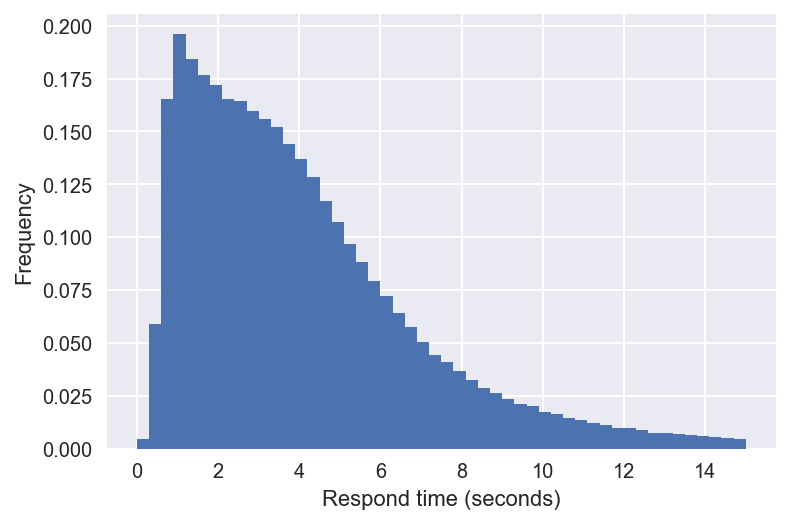

In [5]:
df['response_time'].plot.hist(bins=50, normed=True)
plt.xlabel('Respond time (seconds)')
plt.show()

In [6]:
users = df.participant_uid.unique()
num_users = len(users)
print(num_users, "total users")

9628 total users


## Network delay
How long does our system take to respond?

In [7]:
most_delays = (responses['network_delay'] >= 0) & (responses['network_delay'] <= 2)
df = responses[most_delays]

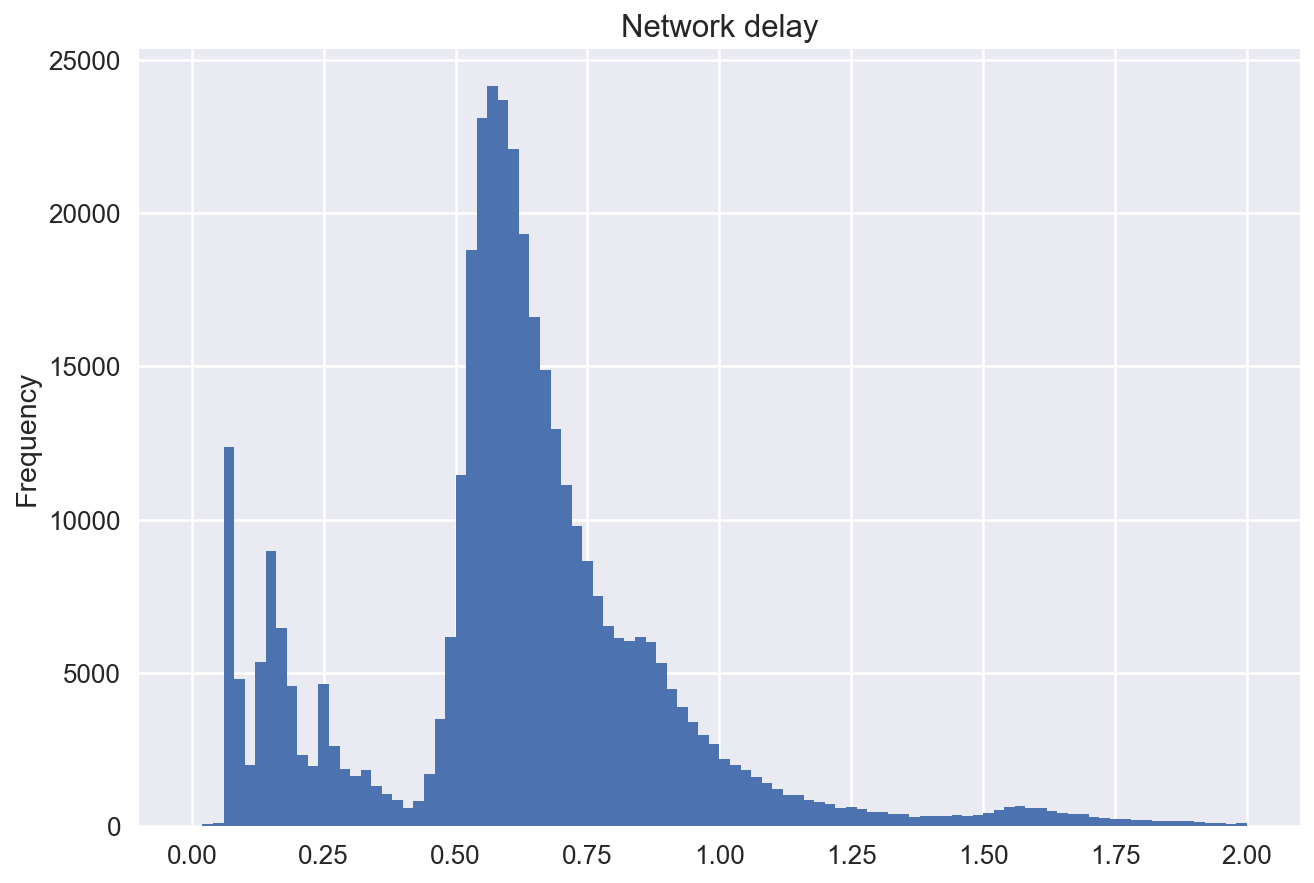

In [8]:
plt.style.use('seaborn-talk')
df['network_delay'].plot.hist(bins=100)
plt.title('Network delay')
plt.show()

## Concurrent users
How many users hit our system in a one second period?

In [9]:
import datetime
df = responses.copy()
contest_start = df['timestamp_query_generated'].min()
contest_end = df['timestamp_query_generated'].max()
df = df.sort_values(by='timestamp_query_generated')
delta = datetime.timedelta(seconds=1)
df['seconds_elapsed'] = df['timestamp_query_generated'] - contest_start
df['seconds_elapsed'] = df.apply(lambda row: row['seconds_elapsed'].total_seconds(), axis=1)

In [10]:
total_seconds = (contest_end - contest_start).total_seconds()

In [14]:
def find_users_in_range(start, k, total, resolution=None, times=None, participants=None):
    if k % 1000 == 0:
        print(k / total, "fraction")
    end = start + resolution
    n_questions = (times >= start) & (times < end)
    n_users = participants[n_questions].nunique()
    
    return {'questions served': n_questions.sum(), 'n_users': n_users, 'start': start, 'end': end}

In [15]:
from joblib import Parallel, delayed

times = df['seconds_elapsed'].values.astype("float32")
participants = df["participant_uid"].apply(hash)

measure = np.linspace(times.min(), times.max(), num=20_000)
print(np.diff(measure).min())
resolution = 5  # seconds
print(f"Launching {len(measure)//1000}k jobs...")
print(f"Resolution: {resolution} seconds")

30.568269038340077
Launching 20k jobs...
Resolution: 5 seconds


In [17]:
kwargs = {"resolution": resolution, "times": times, "participants": participants}
stats = []
for k, m in enumerate(measure):
    stat = find_users_in_range(m, k, len(measure), **kwargs)
    stats.append(stat)

0.0 fraction
0.05 fraction
0.1 fraction
0.15 fraction
0.2 fraction
0.25 fraction
0.3 fraction
0.35 fraction
0.4 fraction
0.45 fraction
0.5 fraction
0.55 fraction
0.6 fraction
0.65 fraction
0.7 fraction
0.75 fraction
0.8 fraction
0.85 fraction
0.9 fraction
0.95 fraction


In [18]:
print(stats[:3])

[{'questions served': 1, 'n_users': 1, 'start': 0.0, 'end': 5.0}, {'questions served': 0, 'n_users': 0, 'start': 30.568269038451923, 'end': 35.56826903845192}, {'questions served': 0, 'n_users': 0, 'start': 61.13653807690385, 'end': 66.13653807690385}]


In [19]:
stats = pd.DataFrame(stats)
stats["minutes"] = stats["start"] / 60
stats["hours"] = stats["minutes"] / 60
stats["days"] = stats["hours"] / 24

In [20]:
stats.sample(n=5)

questions served  n_users          start            end      minutes  \
12154                19       17  371526.741893  371531.741893  6192.112365   
13255                 1        1  405182.406105  405187.406105  6753.040102   
16981                 0        0  519079.776542  519084.776542  8651.329609   
17872                 1        1  546316.104255  546321.104255  9105.268404   
2474                  3        2   75625.897601   75630.897601  1260.431627   

            hours      days  
12154  103.201873  4.300078  
13255  112.550668  4.689611  
16981  144.188827  6.007868  
17872  151.754473  6.323103  
2474    21.007194  0.875300

In [21]:
max_rate = stats['questions served'].max()
print(f'Questions served per {resolution} seconds: {max_rate}')

Questions served per 5 seconds: 96


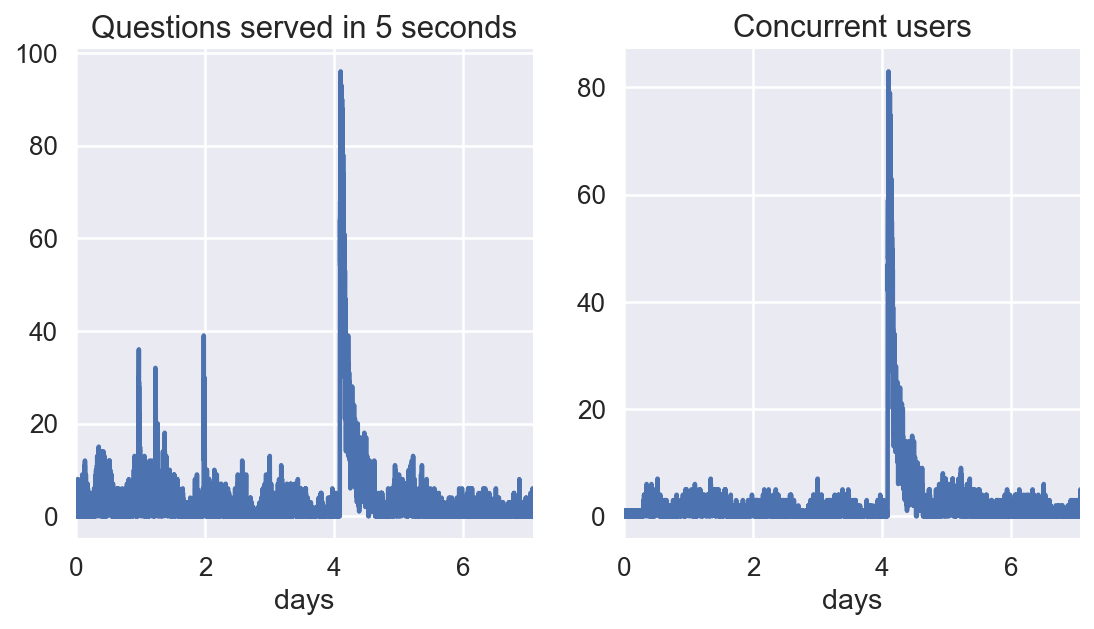

In [22]:
import matplotlib.pyplot as plt

w = 4.5
fig, axs = plt.subplots(ncols=2, figsize=(2 * w, 1*w))
ax = stats.plot(x="days", y="questions served", ax=axs[0])
ax.set_title(f"Questions served in {resolution} seconds")
ax.legend_.remove()

ax = stats.plot(x="days", y="n_users", ax=axs[1])
ax.set_title("Concurrent users")
ax.legend_.remove()

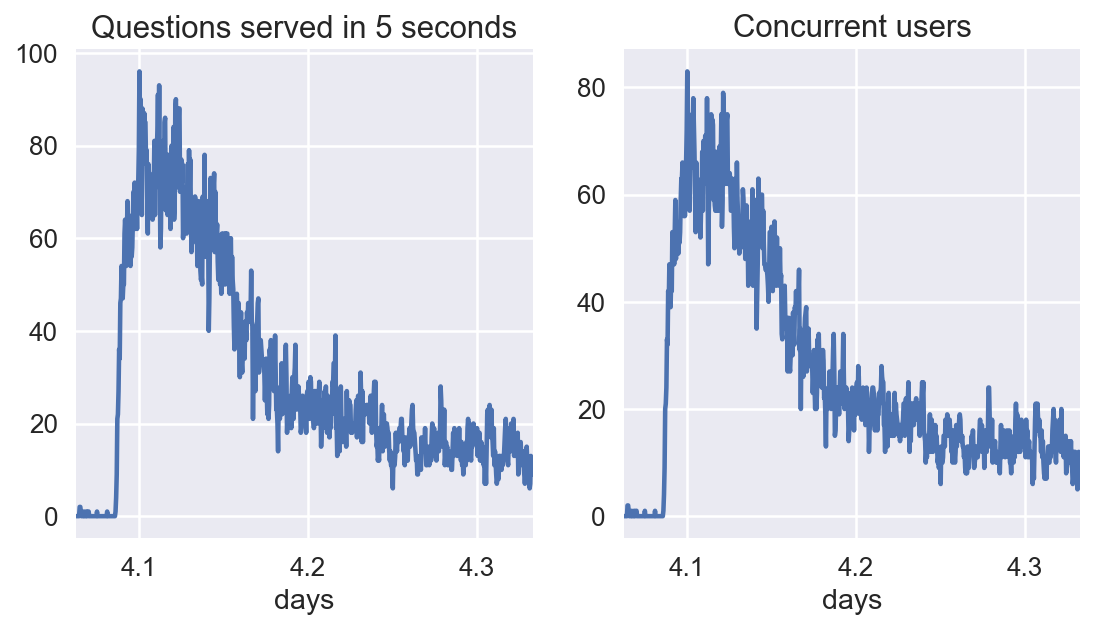

In [23]:
idx = (97.5<= stats.hours) & (stats.hours <= 104)


w = 4.5
fig, axs = plt.subplots(ncols=2, figsize=(2 * w, 1*w))
ax = stats[idx].plot(x="days", y="questions served", ax=axs[0])
ax.set_title(f"Questions served in {resolution} seconds")
ax.legend_.remove()

ax = stats[idx].plot(x="days", y="n_users", ax=axs[1])
ax.set_title("Concurrent users")
ax.legend_.remove()